https://www.geeksforgeeks.org/explain-image-segmentation-techniques-and-applications/

# Exploring the U-Net architecture

In [ ]:
import torch
import torch.nn as nn
model = nn.ConvTranspose2d(1, 1, kernel_size=(2,2), stride=2, padding = 0)

In [ ]:
input = torch.ones(1, 1, 3, 3)
input

tensor([[[[1., 1., 1.],
          [1., 1., 1.],
          [1., 1., 1.]]]])

In [ ]:
output = model(input)
output.shape

torch.Size([1, 1, 6, 6])

In [ ]:
output

tensor([[[[ 0.0626, -0.0415,  0.0626, -0.0415,  0.0626, -0.0415],
          [-0.1082,  0.0712, -0.1082,  0.0712, -0.1082,  0.0712],
          [ 0.0626, -0.0415,  0.0626, -0.0415,  0.0626, -0.0415],
          [-0.1082,  0.0712, -0.1082,  0.0712, -0.1082,  0.0712],
          [ 0.0626, -0.0415,  0.0626, -0.0415,  0.0626, -0.0415],
          [-0.1082,  0.0712, -0.1082,  0.0712, -0.1082,  0.0712]]]],
       grad_fn=<ConvolutionBackward0>)

https://www.kaggle.com/datasets/bulentsiyah/semantic-drone-dataset

In [ ]:
# Step 1: Upload the Kaggle API key
from google.colab import files
files.upload()  # Upload kaggle.json here

# Step 2: Configure Kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Step 3: Download the dataset
!kaggle datasets download -d bulentsiyah/semantic-drone-dataset

# Step 4: Extract the dataset
!unzip semantic-drone-dataset.zip -d semantic-drone-dataset


Saving kaggle.json to kaggle (1).json
Dataset URL: https://www.kaggle.com/datasets/bulentsiyah/semantic-drone-dataset
License(s): other
semantic-drone-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  semantic-drone-dataset.zip
replace semantic-drone-dataset/RGB_color_image_masks/RGB_color_image_masks/000.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: semantic-drone-dataset/RGB_color_image_masks/RGB_color_image_masks/000.png  
  inflating: semantic-drone-dataset/RGB_color_image_masks/RGB_color_image_masks/001.png  
  inflating: semantic-drone-dataset/RGB_color_image_masks/RGB_color_image_masks/002.png  
  inflating: semantic-drone-dataset/RGB_color_image_masks/RGB_color_image_masks/003.png  
  inflating: semantic-drone-dataset/RGB_color_image_masks/RGB_color_image_masks/004.png  
  inflating: semantic-drone-dataset/RGB_color_image_masks/RGB_color_image_masks/005.png  
  inflating: semantic-drone-dataset/RGB_color_image_m

In [ ]:
# import glob

# image_paths = glob.glob("map_segmantation/Tile [1-8]/masks/*.png")

# len(image_paths) # sakhtare khobi baraye khandane image

0

In [ ]:
!pip install -q torch_snippets
from torch_snippets import *
from torchvision import transforms, models, datasets
from torchvision.ops import nms
import torch
from torch import optim
import numpy as np, cv2, pandas as pd, glob, time
import matplotlib.pyplot as plt
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
import random
from PIL import Image

from sklearn.model_selection import train_test_split
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
tfms = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
        [0.229, 0.224, 0.225])
])

In [ ]:
# class SegData(Dataset):
#     def __init__(self,transforms = None):
#         self.origin = glob.glob("/content/semantic-drone-dataset/dataset/semantic_drone_dataset/original_images/*.jpg")
#         self.mask = glob.glob("/content/semantic-drone-dataset/dataset/semantic_drone_dataset/label_images_semantic/*.png")
#         self.transforms = transforms

#     def __len__(self):
#         return len(self.origin)

#     def __getitem__(self, index):
#         image = cv2.imread(self.origin[index],1)[:,:,::-1]
#         image = cv2.resize(image, (224,224))
#         mask = cv2.imread(self.mask[index],0)
#         mask = cv2.resize(mask, (224,224),  interpolation=cv2.INTER_NEAREST)  # Resize with near
#         # if self.transforms is not None:
#         #     image = self.transforms(image)
#         return image, mask

#     def choose(self):
#         return self[random.randint(0,len(self)-1)]

#     def collate_fn(self, batch):
#         ims, masks = list(zip(*batch))  #[(image1,image2),(mask1,mask2)]
#         ims = torch.cat([self.transforms(im)[None] for im in ims]).float().to(device)
#         ce_masks = torch.cat([torch.Tensor(mask[None]) for mask in masks]).long().to(device)
#         return ims, ce_masks


import torch
from torch.utils.data import Dataset
import cv2
import glob
import random

class SegData(Dataset):
    def __init__(self, transforms=None):
        self.origin = sorted(glob.glob("/content/semantic-drone-dataset/dataset/semantic_drone_dataset/original_images/*.jpg"))
        self.mask = sorted(glob.glob("/content/semantic-drone-dataset/dataset/semantic_drone_dataset/label_images_semantic/*.png"))
        assert len(self.origin) == len(self.mask), "Mismatch between images and masks!"
        self.transforms = transforms

    def __len__(self):
        return len(self.origin)

    def __getitem__(self, index):
        # Read and resize image
        image = cv2.imread(self.origin[index], 1)[:, :, ::-1]  # BGR to RGB
        image = cv2.resize(image, (224, 224))

        # Read and resize mask
        mask = cv2.imread(self.mask[index], 0)  # Grayscale
        mask = cv2.resize(mask, (224, 224), interpolation=cv2.INTER_NEAREST)

        if self.transforms:
            image = self.transforms(image)

        return image, mask

    def collate_fn(self, batch):
        ims, masks = zip(*batch)

        # Handle images
        if isinstance(ims[0], torch.Tensor):
            ims = torch.stack(ims).float().to(device)
        else:
            ims = torch.stack([self.transforms(im) if self.transforms else torch.tensor(im).permute(2, 0, 1) for im in ims]).float().to(device)

        # Handle masks
        ce_masks = torch.stack([torch.tensor(mask) for mask in masks]).long().to(device)

        return ims, ce_masks

    def choose(self):   # tabei ke bad az farakhani yek image va yek mask midahad.
        # Choose a random index
        random_index = random.randint(0, len(self) - 1)
        return self[random_index]

# tabe show dar torch baraye namayeshe ax

In [ ]:
full_dataset = SegData(transforms=tfms)
train_ratio = 0.8
train_size = int(train_ratio * len(full_dataset))
valid_size = len(full_dataset) - train_size
train_dataset, valid_dataset = random_split(full_dataset, [train_size, valid_size])

train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True, collate_fn=full_dataset.collate_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=8, shuffle=False, collate_fn=full_dataset.collate_fn)


print("Training dataset size:", len(train_dataset))
print("Validation dataset size:", len(valid_dataset))


for images, masks in train_dataloader:
    print("Training Images shape:", images.shape)  # Shape: (batch_size, channels, height, width)  # baraye etminan az amalkarde dataloader dar yek batch
    print("Training Masks shape:", masks.shape)    # Shape: (batch_size, height, width)
    break

for images, masks in valid_dataloader:
    print("Validation Images shape:", images.shape)  # Shape: (batch_size, channels, height, width)  # baraye etminan az amalkarde dataloader dar yek batch
    print("Validation Masks shape:", masks.shape)    # Shape: (batch_size, height, width)
    break

Training dataset size: 320
Validation dataset size: 80
Training Images shape: torch.Size([8, 3, 224, 224])
Training Masks shape: torch.Size([8, 224, 224])
Validation Images shape: torch.Size([8, 3, 224, 224])
Validation Masks shape: torch.Size([8, 224, 224])


In [ ]:
def conv(in_channels, out_channels):
    return nn.Sequential(
                        nn.Conv2d(in_channels,out_channels,kernel_size=3,stride=1, padding=1),
                        nn.BatchNorm2d(out_channels),
                        nn.ReLU(inplace=True)
                        )

def up_conv(in_channels, out_channels):
    return nn.Sequential(
                        nn.ConvTranspose2d(in_channels, out_channels,kernel_size=2, stride=2),
                        nn.ReLU(inplace=True)
                        )

In [ ]:
backbone = models.vgg16_bn(pretrained = True)

In [ ]:
torch.hub.get_dir()   # masire zakhire model

'/root/.cache/torch/hub'

In [ ]:
backbone

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [ ]:
backbone.features[34:]

Sequential(
  (34): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (35): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (36): ReLU(inplace=True)
  (37): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (38): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (39): ReLU(inplace=True)
  (40): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (41): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (42): ReLU(inplace=True)
  (43): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)

In [ ]:
class UNet(nn.Module):
    def __init__(self, backbone, out_channels=24):
        super().__init__()
        self.encoder= backbone.features
        self.block1 = nn.Sequential(*self.encoder[:6])
        self.block2 = nn.Sequential(*self.encoder[6:13])
        self.block3 = nn.Sequential(*self.encoder[13:20])
        self.block4 = nn.Sequential(*self.encoder[20:27])
        self.block5 = nn.Sequential(*self.encoder[27:34])
        self.bottleneck = nn.Sequential(*self.encoder[34:])
        self.conv_bottleneck = conv(512, 1024)  ########################################################
        self.up_conv6 = up_conv(1024, 512)
        self.conv6 = conv(512 + 512, 512)
        self.up_conv7 = up_conv(512, 256)
        self.conv7 = conv(256 + 512, 256)
        self.up_conv8 = up_conv(256, 128)
        self.conv8 = conv(128 + 256, 128)
        self.up_conv9 = up_conv(128, 64)
        self.conv9 = conv(64 + 128, 64)
        self.up_conv10 = up_conv(64, 32)
        self.conv10 = conv(32 + 64, 32)
        self.conv11 = nn.Conv2d(32, out_channels, kernel_size=1)

    def forward(self, x):
        block1 = self.block1(x)
        block2 = self.block2(block1)
        block3 = self.block3(block2)
        block4 = self.block4(block3)
        block5 = self.block5(block4)
        bottleneck = self.bottleneck(block5)
        x = self.conv_bottleneck(bottleneck)
        x = self.up_conv6(x)
        x = torch.cat([x, block5], dim=1)
        x = self.conv6(x)
        x = self.up_conv7(x)
        x = torch.cat([x, block4], dim=1)
        x = self.conv7(x)
        x = self.up_conv8(x)
        x = torch.cat([x, block3], dim=1)
        x = self.conv8(x)
        x = self.up_conv9(x)
        x = torch.cat([x, block2], dim=1)
        x = self.conv9(x)
        x = self.up_conv10(x)
        x = torch.cat([x, block1], dim=1)
        x = self.conv10(x)
        x = self.conv11(x)
        return x

In [ ]:
ce = nn.CrossEntropyLoss()
def UnetLoss(preds, targets):
    #preds (N, C, H, W)
    #targets (N, H, W)
    # torch.max(preds,1)[1]   extracts the indices
    ce_loss = ce(preds, targets)
    acc = (torch.max(preds,1)[1] == targets).float().mean()
    return ce_loss, acc
def train_batch(model, data, optimizer, criterion):
    model.train()
    ims, ce_masks = data
    _masks = model(ims)
    optimizer.zero_grad()
    loss, acc = criterion(_masks, ce_masks)
    loss.backward()
    optimizer.step()
    return loss.item(), acc.item()
@torch.no_grad()
def validate_batch(model, data, criterion):
    model.eval()
    ims, masks = data
    _masks = model(ims)
    loss, acc = criterion(_masks, masks)
    return loss.item(), acc.item()

In [ ]:
model = UNet(backbone=backbone).to(device)
criterion = UnetLoss
optimizer = optim.Adam(model.parameters(), lr=1e-3)
n_epochs = 5

EPOCH: 1.000  trn_acc: 0.538  val_loss: 1.764  val_acc: 0.648  trn_loss: 2.322  (221.46s - 885.84s remaining)
EPOCH: 2.000  trn_acc: 0.657  val_loss: 1.555  val_acc: 0.670  trn_loss: 1.661  (436.25s - 654.38s remaining)
EPOCH: 3.000  trn_acc: 0.665  val_loss: 1.381  val_acc: 0.645  trn_loss: 1.381  (648.09s - 432.06s remaining)
EPOCH: 4.000  trn_acc: 0.710  val_loss: 1.109  val_acc: 0.703  trn_loss: 1.137  (859.64s - 214.91s remaining)
EPOCH: 5.000  trn_acc: 0.723  val_loss: 0.926  val_acc: 0.745  trn_loss: 1.021  (1071.58s - 0.00s remaining)


100%|██████████| 106/106 [00:00<00:00, 13798.77it/s]


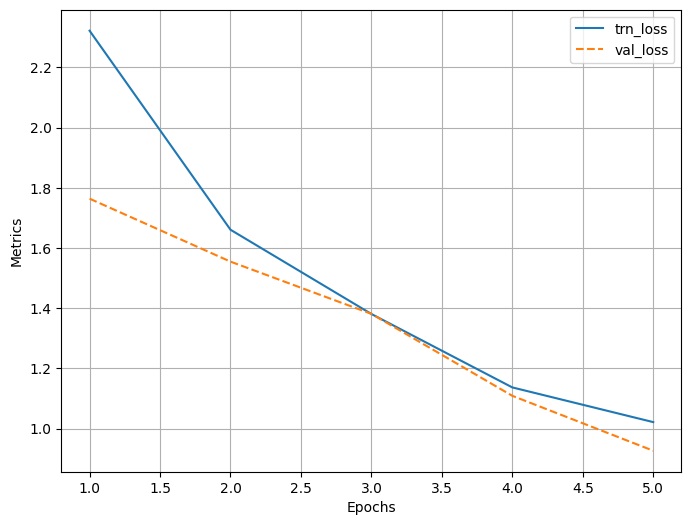

In [ ]:
from torch_snippets.torch_loader import Report
log = Report(n_epochs)
for ex in range(n_epochs):
    N = len(train_dataloader)
    for bx, data in enumerate(train_dataloader):
        loss, acc = train_batch(model, data, optimizer, criterion)
        log.record(ex+(bx+1)/N,trn_loss=loss,trn_acc=acc, end='\r')
    N = len(valid_dataloader)
    for bx, data in enumerate(valid_dataloader):
        loss, acc = validate_batch(model, data, criterion)
        log.record(ex+(bx+1)/N,val_loss=loss,val_acc=acc, end='\r')
    log.report_avgs(ex+1)
log.plot_epochs(['trn_loss','val_loss'])

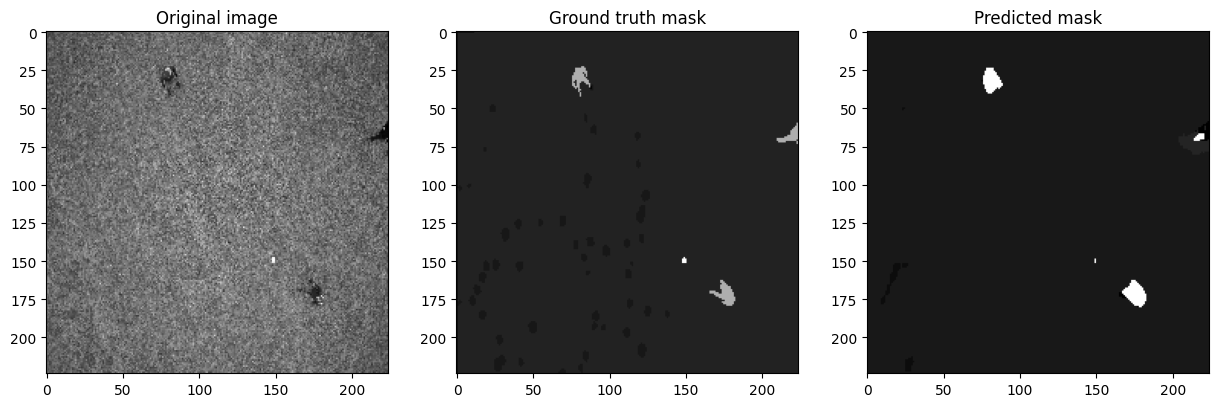

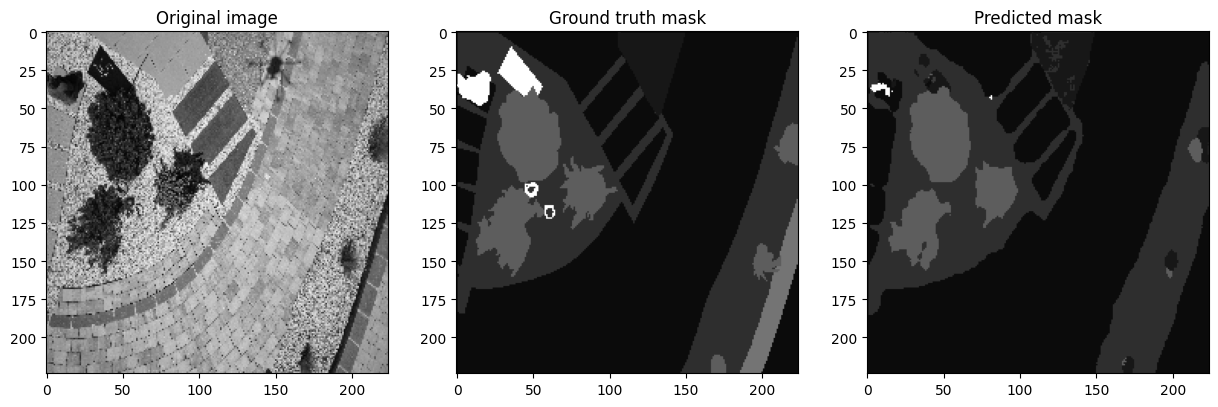

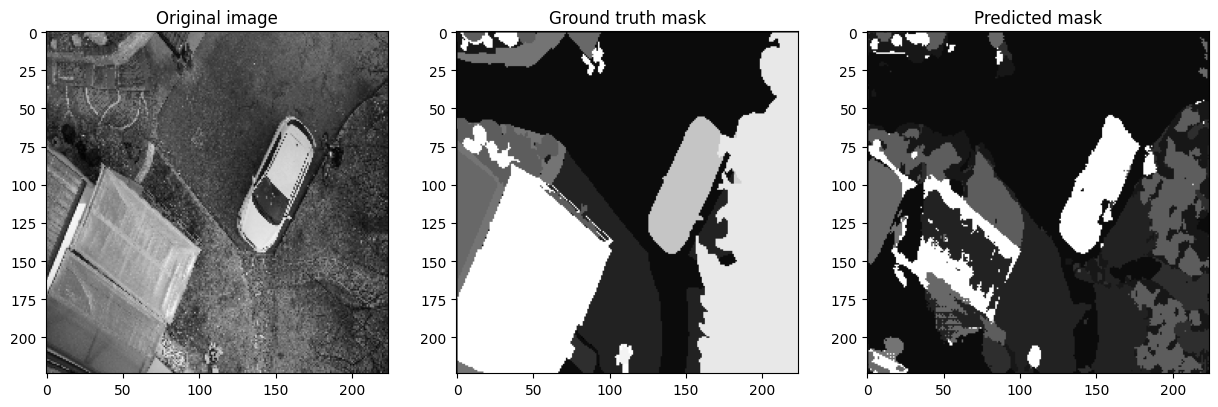

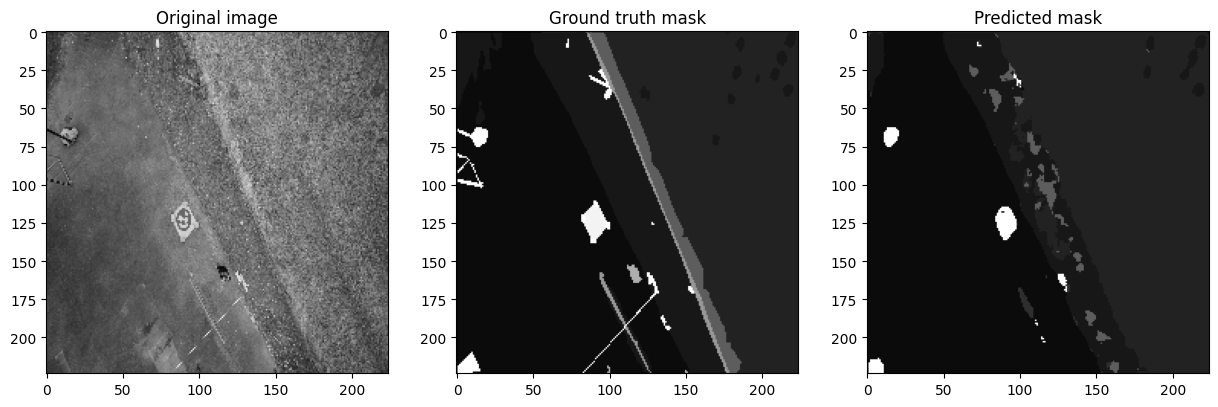

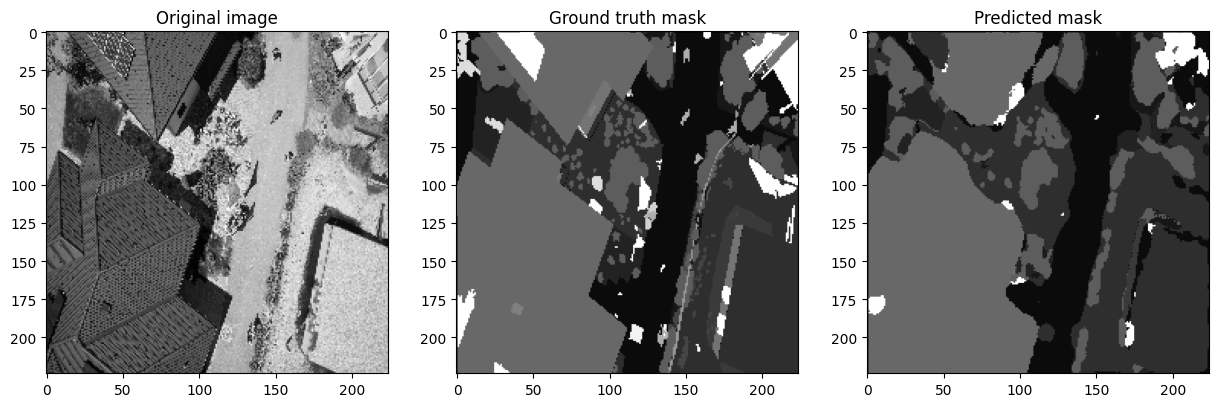

In [ ]:
N = 5
for i, (im,mask) in enumerate(valid_dataloader):
    if i == 5:
        break
    model.eval()
    plt.figure(figsize=(15,8))
    im, mask = (im,mask)
    _mask = model(im)
    _, _mask = torch.max(_mask, dim=1)
    plt.subplot(131)
    plt.imshow(im[0].permute(1,2,0).detach().cpu()[:,:,0], cmap='gray')
    plt.title('Original image')
    plt.subplot(132)
    plt.imshow(mask.permute(1,2,0).detach().cpu()[:,:,0], cmap='gray')
    plt.title('Ground truth mask')
    plt.subplot(133)
    plt.imshow(_mask.permute(1,2,0).detach().cpu()[:,:,0], cmap='gray')
    plt.title('Predicted mask')
    plt.show()


In [ ]:
data = SegData()

In [ ]:
len(data)

400

In [ ]:
data = SegData()
random_image, random_mask = data.choose()

In [ ]:
im[1].shape

torch.Size([3, 224, 224])

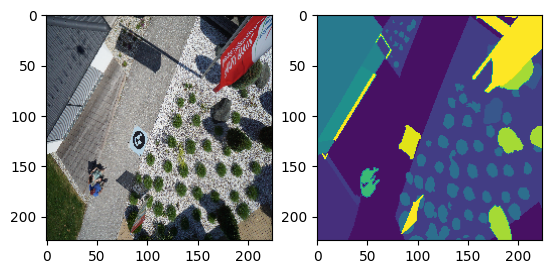

In [ ]:
import matplotlib.pyplot as plt
im = data.choose()
plt.subplot(1,2,1)
plt.imshow(im[0])
plt.subplot(1,2,2)
plt.imshow(im[1])

In [ ]:
np.unique(im[1])

array([ 0,  1,  3,  4,  6,  8,  9, 10, 11, 15, 19, 21, 22], dtype=uint8)

array([[ 0,  9,  9, ...,  4,  4,  4],
       [ 0,  9,  9, ..., 22, 22, 22],
       [ 0,  9,  9, ..., 22, 22, 22],
       ...,
       [ 0,  3,  3, ...,  1,  1,  1],
       [ 0,  3,  3, ...,  1,  1,  1],
       [ 0,  3,  3, ...,  1,  1,  1]], dtype=uint8)
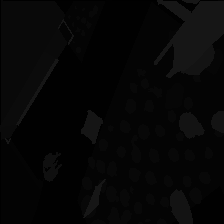

In [ ]:
im[1]

In [ ]:
i = tfms(im[0]).float()

In [ ]:
i

tensor([[[-1.3644, -1.3473, -1.1760,  ..., -1.0390, -0.3712, -0.6965],
         [-1.4500, -1.2103, -1.2274,  ...,  0.1083, -0.8335,  0.3481],
         [-1.3987, -1.4500, -1.3987,  ..., -0.8335,  0.3994,  0.3138],
         ...,
         [-1.7240, -1.6898, -1.4843,  ...,  0.3994,  0.2624,  0.2796],
         [-1.5870, -1.7412, -1.3815,  ...,  0.3481,  0.1254, -0.0629],
         [-1.6213, -1.5014, -1.5014,  ..., -0.3712,  0.3138,  0.2282]],

        [[-1.0903, -1.0378, -0.9328,  ..., -0.1800, -0.0049,  0.1176],
         [-1.1954, -1.0553, -0.8803,  ...,  0.5203,  0.0476,  0.7829],
         [-1.1253, -1.1253, -1.1604,  ...,  0.0476,  0.7304,  0.8179],
         ...,
         [-1.3354, -1.3179, -1.1429,  ...,  0.2752,  0.1352,  0.2927],
         [-1.2479, -1.3354, -1.1078,  ...,  0.2227,  0.0126,  0.0476],
         [-1.2479, -1.1253, -1.1779,  ..., -0.5651,  0.1877,  0.2052]],

        [[-0.6890, -0.6193, -0.4798,  ...,  0.1302,  0.7054,  0.9494],
         [-0.7936, -0.6890, -0.6367,  ...,  1

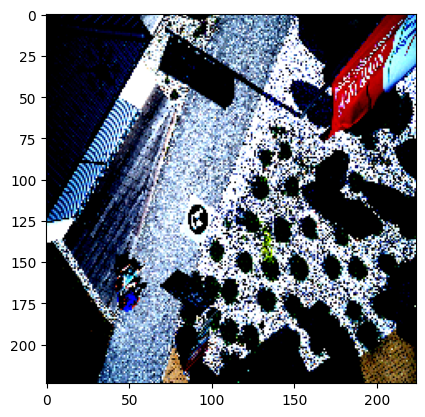

In [ ]:
plt.imshow(i.numpy().transpose(1,2,0))

In [ ]:
import torch
import torch.nn as nn

# Example U-Net output (batch_size=2, n_classes=3, height=128, width=128)
output = torch.randn(2, 3, 128, 128)  # Shape: (batch_size, n_classes, height, width)

# Example ground truth mask (batch_size=2, height=128, width=128)
target = torch.randint(0, 3, (2, 128, 128))  # Shape: (batch_size, height, width)

# Define the loss function
criterion = nn.CrossEntropyLoss()

# Calculate the loss
loss = criterion(output, target)

print("Loss:", loss.item())

Loss: 1.3911933898925781


In [ ]:
target.shape

torch.Size([2, 128, 128])

In [ ]:
target[0].shape

torch.Size([128, 128])

In [ ]:
output[0].shape

torch.Size([3, 128, 128])